# Chapter 7 Bilingual PySpark: Blending Python and SQL code

This chapter covers

- Drawing a parallel between PySpark’s instruction set and the SQL vocabulary
- Registering data frames as temporary views or tables to query them using Spark SQL
- Using the catalog to create, reference, and delete registered tables for SQL querying
- Translating common data manipulations instructions from Python to SQL, and vice versa
- Using SQL-style clauses inside certain PySpark methods

# Start a pyspark session

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T
import helper_functions
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# change the account name to your email account
account='sli'

# define a root path to access the data in the DataAnalysisWithPythonAndPySpark
root_path='/net/clusterhn/home/'+account+'/isa460/Data/'

# check if the Spark session is active. If it is activate, close it

try:
    if spark:
        spark.stop()
except:
    pass    

spark = (SparkSession.builder.appName("Multidimensional Data Frame")
        .config("spark.port.maxRetries", "100")
        .getOrCreate())

# confiture the log level (defaulty is WARN)
spark.sparkContext.setLogLevel('ERROR')

In [ ]:
from helper_functions import displayByGroup

elements = spark.read.csv(
    root_path+"elements/Periodic_Table_Of_Elements.csv",
    header=True,
    inferSchema=True)

displayByGroup(elements, 5)

# Register a data frame as a SQL table

In [ ]:
elements.createOrReplaceTempView("elements_t")

In [ ]:
sql="select period, count(*) from elements_t where phase='liq' group by period"
spark.sql(sql).show(5)

## Using the Spark catalog to manage SQL table/view

In [ ]:
spark.catalog

In [ ]:
# list all sql tables
spark.catalog.listTables()

In [ ]:
# drop sql table/view
spark.catalog.dropTempView("elements_t")

# Using SQL-style expressions in PySpark

we will use a public data set provided by Backblaze, which provided hard-drive data and statistics. Backblaze is a company that provides cloud storage and backup. Since 2013, they have provided data on the drives in their data center, and over time have moved to a focus on failures and diagnosis. To get the files, you can download them from the website (http://mng.bz/4jZa). We will use the latest data in June 2023.

In [ ]:
df=spark.read.csv('/opt/shared/backblaze/', header=True, inferSchema=True)

In [ ]:
df.count()

## Identify the model having the highest failure rate.

In [ ]:
# select only the useful columns for our query
selected_columns=['date',
 'serial_number',
 'model',
 'capacity_bytes',
 'failure']


df1=df.select(selected_columns)

df1.show(10, False)

In [ ]:
# get driver capacity in gigabytes

df2=df1.selectExpr("model", "capacity_bytes/power(1024,3) capacity_GB", "date", "failure")

df2.show()

In [ ]:
# calcualte failure rate by model

df3=df2.groupBy('model', 'capacity_GB', 'failure').count().orderBy('model', 'capacity_GB')

df4=df3.groupBy('model', 'capacity_GB').pivot('failure').sum('count')

In [ ]:
df5=df4.filter(F.col('1').isNotNull()).withColumn('failure_rate', F.col('1')/(F.col('0')+F.col('1'))).orderBy(F.desc('failure_rate'))

df5.show()

In [ ]:
# is there a correlation between capacity and failure_rate

df5.select(F.corr('capacity_GB', 'failure_rate')).show()

## SQL and Pyspark code comparison

In [ ]:
df=spark.read.csv('/opt/shared/backblaze/', header=True, inferSchema=True)

selected_columns=['date',
 'serial_number',
 'model',
 'capacity_bytes',
 'failure']


backblaze=df.select(selected_columns)

backblaze.createOrReplaceTempView("backblaze_t")

### display the top 3 models that have the highest max capacity


In [ ]:
# SQL way
spark.sql(
    """SELECT
           model,
           min(capacity_bytes / pow(1024, 3)) min_GB,
           max(capacity_bytes/ pow(1024, 3)) max_GB
        FROM backblaze_t
        GROUP BY 1
        ORDER BY 3 DESC"""
).show(5)

In [ ]:
#Pyspark way

backblaze.groupby(F.col("model")).agg(
    F.min(F.col("capacity_bytes") / F.pow(F.lit(1024), 3)).alias("min_GB"),
    F.max(F.col("capacity_bytes") / F.pow(F.lit(1024), 3)).alias("max_GB"),
).orderBy(F.col("max_GB"), ascending=False).show(5) 

### display the top 3 models that have the highest max capacity, remove model that min capacity is equal to max capacity

filtering after grouping using having

In [ ]:
# SQL way
spark.sql(
    """SELECT
           model,
           min(capacity_bytes / pow(1024, 3)) min_GB,
           max(capacity_bytes/ pow(1024, 3)) max_GB
        FROM backblaze_t
        GROUP BY 1
        HAVING min_GB!=max_GB
        ORDER BY 3 DESC"""
).show(5)

In [ ]:
#Pyspark way

backblaze.groupby(F.col("model")).agg(
    F.min(F.col("capacity_bytes") / F.pow(F.lit(1024), 3)).alias("min_GB"),
    F.max(F.col("capacity_bytes") / F.pow(F.lit(1024), 3)).alias("max_GB"),
).where(F.col("min_GB") != F.col("max_GB")).orderBy(F.col("max_GB"), ascending=False).show(5) 

## Creating new tables/views using the CREATE keyword

In [ ]:
spark.sql(
    """
    CREATE OR REPLACE TEMP VIEW drive_days AS
        SELECT model, count(*) AS drive_days
        FROM backblaze_t
        GROUP BY model"""
)
 
spark.sql(
    """CREATE OR REPLACE TEMP VIEW failures AS
           SELECT model, count(*) AS failures
           FROM backblaze_t
           WHERE failure = 1
           GROUP BY model"""
)

In [ ]:
spark.catalog.listTables()

### Adding data to our table using UNION and JOIN

In [ ]:
backblaze_failure=backblaze.filter(F.col('failure')==1)
backblaze_working=backblaze.filter(F.col('failure')==0)

backblaze_failure.createOrReplaceTempView('backblaze_failure_t')
backblaze_working.createOrReplaceTempView('backblaze_working_t')

In [ ]:
# sql way
spark.sql("""
        create or replace temp view backblaze_complete as
        select * from backblaze_failure_t union all
        select * from backblaze_working_t
""")

#pyspark way

backblaze_complet=backblaze_failure.union(backblaze_working)

# left join
spark.sql(
    """select
           drive_days.model,
           drive_days,
           failures
    from drive_days
    left join failures on drive_days.model = failures.model"""
).show(5)

### Organizing your SQL code better through subqueries and common table expressions

In [ ]:
spark.sql("select * from backblaze_t").show()

In [ ]:
# Finding drive models with highest failure rates using subqueries

spark.sql(
    """
    SELECT
        failures.model,
        failures / drive_days failure_rate
    FROM (
        SELECT
            model,
            count(*) AS drive_days
        FROM backblaze_t
        GROUP BY model) drive_days
    INNER JOIN (
        SELECT
            model,
            count(*) AS failures
        FROM backblaze_t
        WHERE failure = 1
        GROUP BY model) failures
    ON
        drive_days.model = failures.model
    ORDER BY 2 desc
    """
).show(5)

In [ ]:
# Finding highest failure rates using common table expressions/CTE
spark.sql(
    """
    WITH drive_days as (            
        SELECT                       
            model,                   
            count(*) AS drive_days   
        FROM backblaze_t            
        GROUP BY model),             
    failures as (                    
        SELECT                      
            model,                   
            count(*) AS failures    
        FROM backblaze_t            
        WHERE failure = 1           
        GROUP BY model)              
    SELECT
        failures.model,
        failures / drive_days failure_rate
    FROM drive_days
    INNER JOIN failures
    ON
        drive_days.model = failures.model
    ORDER BY 2 desc
    """
).show(5)


In [ ]:
# Finding the highest failure rate using Python scope rules

def failure_rate(df):
    drive_days = df.groupby(F.col("model")).agg(   
        F.count(F.col("*")).alias("drive_days")
    )
    failures = (
       df.where(F.col("failure") == 1)
        .groupby(F.col("model"))
        .agg(F.count(F.col("*")).alias("failures"))
    )
    answer = (                                               
        drive_days.join(failures, on="model", how="inner")
        .withColumn("failure_rate", F.col("failures") / F.col("drive_days"))
        .orderBy(F.col("failure_rate").desc())
    )
    return answer

In [ ]:
failure_rate(backblaze).show()

In [ ]:
def most_reliable_drive_for_capacity(data, capacity_GB=2048, precision=0.25, top_n=3):
    """Returns the top 3 drives for a given approximate capacity.
 
    Given a capacity in GB and a precision as a decimal number, we keep the N
    drives where:
 
    - the capacity is between (capacity * 1/(1+precision)), capacity * (1+precision)
    - the failure rate is the lowest
 
    """
    capacity_min = capacity_GB / (1 + precision)
    capacity_max = capacity_GB * (1 + precision)
 
    answer = (
        data.where(f"capacity_GB between {capacity_min} and {capacity_max}")
        .orderBy("failure_rate", "capacity_GB", ascending=[True, False])
        .limit(top_n)                                                     
     )
 
    return answer

In [ ]:
backblaze1=backblaze.withColumn('capacity_GB', F.col("capacity_bytes") / F.pow(F.lit(1024), 3))

most_reliable_drive_for_capacity(df5, capacity_GB=11176.0).show()

#Summary

- Spark provides a SQL API for data manipulation. This API supports ANSI SQL.
- Spark (and PySpark, by extension) borrows a lot of vocabulary and expected functionality from the way SQL manipulates tables. This is especially evident since the data manipulation module is called pyspark.sql.
- PySpark’s data frames need to be registered as views or tables before they can be queried with Spark SQL. You can give them a different name than the data frame you’re registering.
- PySpark’s own data frame manipulation methods and functions borrow SQL functionality, for the most part. Some exceptions, such as union(), are present and documented in the API.
- Spark SQL queries can be inserted in a PySpark program through the spark.sql function, where spark is the running SparkSession.
- Spark SQL table references are kept in a Catalog, which contains the metadata for all tables accessible to Spark SQL.
- PySpark will accept SQL-style clauses in where(), expr(), and selectExpr(), which can simplify the syntax for complex filtering and selection.
- When using Spark SQL queries with user-provided input, be careful with sanitizing the inputs to avoid potential SQL injection attacks.

## In class exercise

display average failur rate of driver by day, order by day, and visualize the result.

Use both SQL and pyspark to get the answer. Which one you prefer?

In [20]:
df=spark.read.csv('/opt/shared/backblaze/', header=True, inferSchema=True)

selected_columns=['date',
 'serial_number',
 'model',
 'capacity_bytes',
 'failure']


backblaze=df.select(selected_columns)

backblaze.createOrReplaceTempView("backblaze_t")

## PySpark way

In [21]:
df=backblaze.groupBy('date', 'failure').count()
df1=df.groupBy('date').pivot('failure').sum('count')
df2=df1.withColumn('failure_rate', F.col('1')/(F.col('1')+F.col('0'))).orderBy('date')
df2.show()

+----------+------+---+--------------------+
|      date|     0|  1|        failure_rate|
+----------+------+---+--------------------+
|2023-06-01|245687| 21| 8.54673026519283E-5|
|2023-06-02|245686| 10|4.070070330815316...|
|2023-06-03|245751|  6| 2.44143605268619E-5|
|2023-06-04|245750|  9|3.662124276221827...|
|2023-06-05|245744|  9|3.662213686099458E-5|
|2023-06-06|245715|  7|2.848747771872278...|
|2023-06-07|245746| 11|4.475966096591348E-5|
|2023-06-08|245743| 10|4.069126317888286E-5|
|2023-06-09|245716|  9|3.662630989927764...|
|2023-06-10|245750|  7|2.848342061467221...|
|2023-06-11|245753|  3|1.220722993538306...|
|2023-06-12|245731| 24|9.765823686191533E-5|
|2023-06-13|245750|  2|8.138285751489307E-6|
|2023-06-14|245732| 26|1.057951317963199...|
|2023-06-15|245728| 30|1.220713059188307...|
|2023-06-16|245744| 12|4.882891974153225E-5|
|2023-06-17|245749| 11|4.475911458333333E-5|
|2023-06-18|245752|  7|2.848318881505865...|
|2023-06-19|245741| 18|7.324248552443655E-5|
|2023-06-2

### SQL way

In [27]:
spark.sql('select * from backblaze_t').show()

+----------+--------------+--------------------+--------------+-------+
|      date| serial_number|               model|capacity_bytes|failure|
+----------+--------------+--------------------+--------------+-------+
|2023-06-28|PL1331LAGDJ5GH|HGST HDS5C4040ALE630| 4000787030016|      0|
|2023-06-28|PL2331LAGLW5UJ|HGST HMS5C4040BLE640| 4000787030016|      0|
|2023-06-28|PL2331LAGM410J|HGST HMS5C4040BLE640| 4000787030016|      0|
|2023-06-28|PL2331LAGM5NTJ|HGST HMS5C4040BLE640| 4000787030016|      0|
|2023-06-28|PL2331LAGM5R4J|HGST HMS5C4040BLE640| 4000787030016|      0|
|2023-06-28|PL2331LAGM82LJ|HGST HMS5C4040BLE640| 4000787030016|      0|
|2023-06-28|PL2331LAGM9J9J|HGST HMS5C4040BLE640| 4000787030016|      0|
|2023-06-28|PL2331LAGM9Y6J|HGST HMS5C4040BLE640| 4000787030016|      0|
|2023-06-28|PL2331LAGMAPRJ|HGST HMS5C4040BLE640| 4000787030016|      0|
|2023-06-28|PL2331LAGMDMLJ|HGST HMS5C4040BLE640| 4000787030016|      0|
|2023-06-28|PL2331LAGMEZPJ|HGST HMS5C4040BLE640| 4000787030016| 

In [33]:
sql="""
    select date, total_working, total_failure, total_failure/(total_working+total_failure) as failure_rate
    from
    (select date, sum(case when failure=0 then 1 else 0 end) as total_working,
                 sum(case when failure=1 then 1 else 0 end) as total_failure
    from backblaze_t
    group by date) t
    order by date
"""

spark.sql(sql).show()

# store results into a data frame
df2=spark.sql(sql)

+----------+-------------+-------------+--------------------+
|      date|total_working|total_failure|        failure_rate|
+----------+-------------+-------------+--------------------+
|2023-06-01|       245687|           21| 8.54673026519283E-5|
|2023-06-02|       245686|           10|4.070070330815316...|
|2023-06-03|       245751|            6| 2.44143605268619E-5|
|2023-06-04|       245750|            9|3.662124276221827...|
|2023-06-05|       245744|            9|3.662213686099458E-5|
|2023-06-06|       245715|            7|2.848747771872278...|
|2023-06-07|       245746|           11|4.475966096591348E-5|
|2023-06-08|       245743|           10|4.069126317888286E-5|
|2023-06-09|       245716|            9|3.662630989927764...|
|2023-06-10|       245750|            7|2.848342061467221...|
|2023-06-11|       245753|            3|1.220722993538306...|
|2023-06-12|       245731|           24|9.765823686191533E-5|
|2023-06-13|       245750|            2|8.138285751489307E-6|
|2023-06

In [24]:
# visualize the result

pd_df=df2.toPandas()
pd_df.head()

,date,0,1,failure_rate
0,2023-06-01,245687,21,0.000085
1,2023-06-02,245686,10,0.000041
2,2023-06-03,245751,6,0.000024
3,2023-06-04,245750,9,0.000037
4,2023-06-05,245744,9,0.000037


<Axes: xlabel='date', ylabel='failure_rate'>

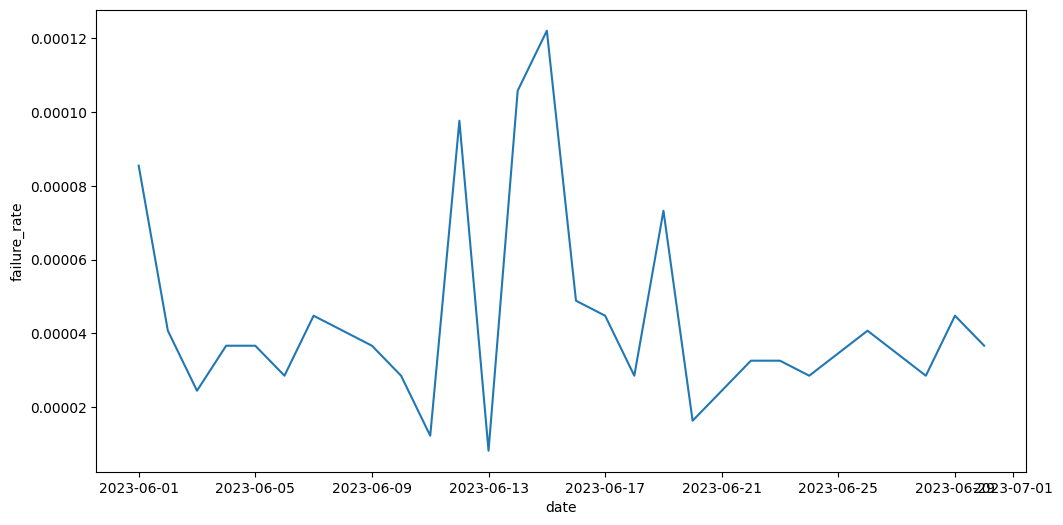

In [26]:
# set the fiture size
plt.figure(figsize=(12,6))

sns.lineplot(data=pd_df, y='failure_rate',x="date")